In [1]:
import numpy as np
from pandas.io.json import json_normalize
import pandas as pd
import json
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

import nltk 
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from wordcloud import WordCloud, STOPWORDS

In [2]:
main = pd.read_csv('ted_main.csv')
transcript = pd.read_csv('transcripts.csv')
main= main.merge(transcript, how='inner',on='url')

In [3]:
main.shape

(2451, 49)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def transform_date(date):
    date_info = datetime.date.fromtimestamp(int(date))
    return date_info
    
main['film_date'] = main['film_date'].apply(transform_date)
main['published_date'] = main['published_date'].apply(transform_date)
main['year'] = main['film_date'].apply(lambda x:str(x).split('-')[0])
main['month'] = main['film_date'].apply(lambda x:str(x).split('-')[1])

In [6]:
main.drop(columns=['film_date','published_date'],inplace=True)

## Step1 Data Cleaning And Information Extraction

#### There are json format data in columns 'ratings' and 'related_talks'. The first step is to clean data and extract useful information from the two columns. Ratings: Descriptive words about talks with counts. Related_talks: the information of the talks related about the main talk.

In [7]:
rating = [json.loads(i.replace("'", "\"")) for i in main.ratings]
print('Check first row:')
print(rating[0])

Check first row:
[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]


#### Data format inside 'Related' is more complex. We can not simply load it in json format. I will adjust the format and extract data with regular expression

In [8]:
try:
    related = [json.loads(i.replace("'", "\"")) for i in main['relaed_talks']]
except KeyError:
    print('error')

error


In [9]:
lst = main['related_talks'].values.tolist()
new = []
for i in lst:
    title = re.findall(r'\'title.*?[\"\'],',i)
    speaker = re.findall(r'\'speaker.*?[\"\'],',i)
    for a,b in zip(title, speaker):
        clean_title = a[10:-2].replace('\"', ' ').replace("'", ' ')
        clean_title = a[:10]+clean_title+a[-2:]
        clean_speaker = b[12:-2].replace('\"', ' ').replace("'", ' ')
        clean_speaker = b[:12]+clean_speaker+b[-2:]
        i = i.replace(a,clean_title).replace(b,clean_speaker)
    new.append(i)

clean=[]
for i in new:
    hero = re.findall(r'\'hero.*?jpg\',',i)
    slug = re.findall(r'\'slug.*?\',',i)
    assert len(hero) == len(slug) > 0
    for x,y in zip(hero, slug):
        i = i.replace(x,'').replace(y,'')
    clean.append(i)
related = [json.loads(i.replace("'", "\"").replace("\\", "\\\\")) for i in clean]

In [10]:
df = main.copy()
df['ratings'],df['related_talks']  = rating, related
df.shape

(2451, 49)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2450
Data columns (total 49 columns):
comments              2451 non-null object
description           2451 non-null object
duration              2451 non-null object
event                 2451 non-null object
languages             2451 non-null object
main_speaker          2451 non-null object
name                  2451 non-null object
num_speaker           2451 non-null object
ratings               2451 non-null object
related_talks         2451 non-null object
speaker_occupation    2445 non-null object
title                 2451 non-null object
url                   2451 non-null object
views                 2451 non-null object
Unnamed: 16           0 non-null object
Unnamed: 17           0 non-null object
Unnamed: 18           0 non-null object
Unnamed: 19           0 non-null object
Unnamed: 20           0 non-null object
Unnamed: 21           0 non-null object
Unnamed: 22           0 non-null object
Unnamed: 23

In [12]:
## speaker_occupation has missing values
df.fillna('unknown', inplace = True)

#### Seems that every review has same descriptive words but different counts. So, I can do word count for every ted talk review and transfer every review word into new columns. 

In [13]:
words=json_normalize(df.ratings[0]).set_index('name').drop(columns=['id']).T
for i in range(1,len(df)):
    words=pd.concat([words,json_normalize(df.ratings[i]).set_index('name').drop(columns=['id']).T])
    
words = words.reset_index(drop=True)
df=df.join(words,how='outer').drop(columns=['ratings','url','event'])

#### Tansfer related talks into new columns

In [14]:
talks=json_normalize(df['related_talks'][0])
t1 = json_normalize(df['related_talks'][0])[['id']].T
for i in range(1,len(df)):
    talks = pd.concat([talks,json_normalize(df['related_talks'][i])])
    t1=t1.append(json_normalize(df['related_talks'][i])[['id']].T)
    
talks.drop_duplicates(subset='id', keep='first', inplace=True)
talks.to_csv('RelatedTalks.csv',index=False)

t1.columns=['related_id1','related_id2','related_id3','related_id4','related_id5','related_id6']
t1.reset_index(inplace=True)


df=df.join(t1)
df.drop(columns=['related_talks'],inplace=True)

In [15]:
df.to_csv('ted.csv',index=False)

## Step2 Statistical Description

In [16]:
df = pd.read_csv('ted.csv')

In [65]:
def groupbox(df,col1,col2,ymin,ymax):
    charts=sns.boxplot(x=col1,y=col2,data=df)
    charts.axis(ymin=ymin, ymax=ymax)
    for item in charts.get_xticklabels():
            item.set_rotation(90)
    sns.set(font_scale=0.5)
    
def groupline(df,col1,col2):
    data=df.groupby(col1)[col2].mean().reset_index()
    chart=sns.lineplot(x=data[col1],y=data[col2])
    for item in chart.get_xticklabels():
            item.set_rotation(90)
    chart.set_xlabel(col1,fontsize=20)
    chart.set_ylabel('mean of '+col2,fontsize=20)
    chart.set_title(label = 'mean of '+col2+' in years',fontsize=30,weight='bold')

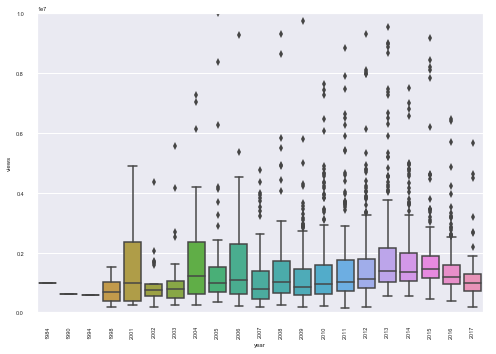

In [67]:
charts=groupbox(df,'year','views',1e4,1e7)

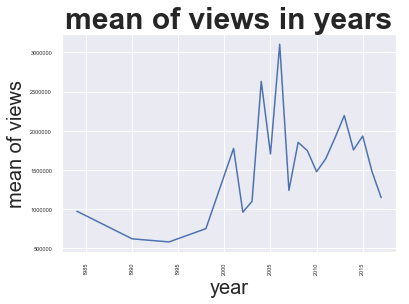

In [19]:
sns.set_style(style='darkgrid')
groupline(df,'year','views')

In [20]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']

In [21]:
df['posCount']=df.loc[:,Positive].sum(axis=1)+1
df['negCount']=df.loc[:,Negative].sum(axis=1)+1

In [22]:
df['popularity']=df['posCount']/df['negCount']

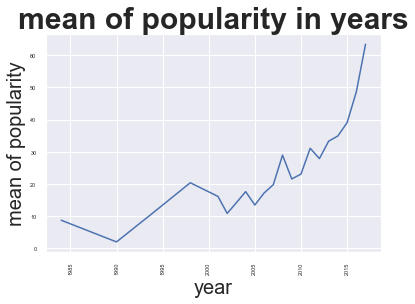

In [23]:
sns.set_style(style='darkgrid')
groupline(df,'year','popularity')

In [24]:
df['wordCount'] = df['transcript'].apply(lambda x: len(nltk.word_tokenize(x)))

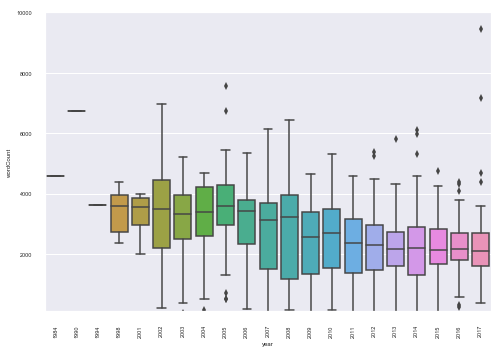

In [69]:
groupbox(df,'year','wordCount',1e2,1e4)

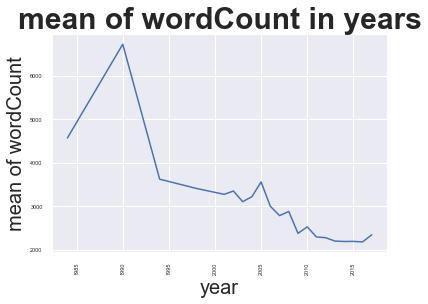

In [26]:
groupline(df,'year','wordCount')

## Step3 Word Frequency

In [27]:
mostView = df.sort_values(by='views',ascending = False)['transcript'][:10]
mostView = mostView.apply(lambda x:nltk.word_tokenize(x))

In [28]:
text=[]
for i in mostView:
    text+=i
POS_text = nltk.pos_tag(text)
POS_text_listN = [word for (word,tag) in POS_text if tag.startswith('N')]

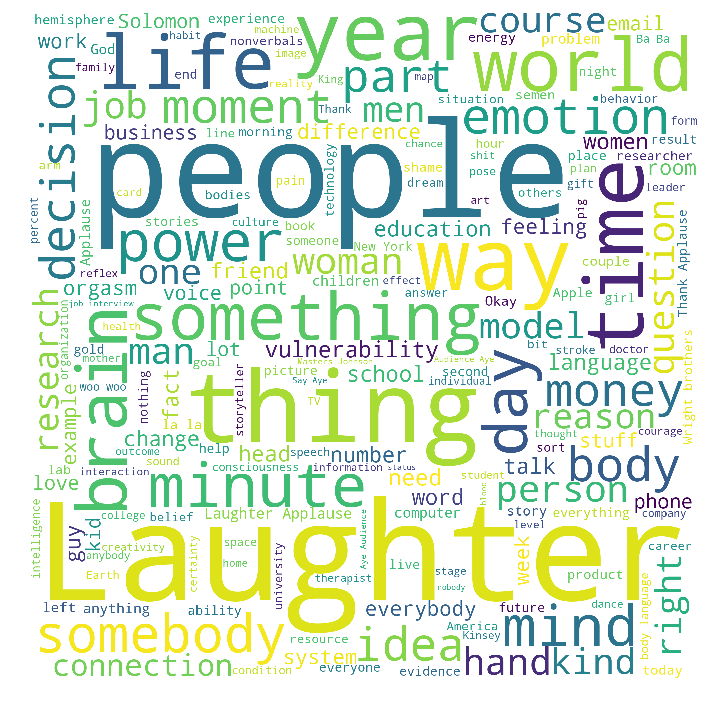

In [29]:
txt=''
for i in POS_text_listN:
    txt=txt+i+' '
txt[:10]
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2000,height=2000).generate(txt)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
df['laughCounts'] = [int(df['transcript'][i].count('Laughter')) for i in range(len(df))]

## Step4 Sentimental Analysis

In [31]:
sid = SentimentIntensityAnalyzer()
output = []
for i in range(0, len(df)):
    ss = sid.polarity_scores(df['transcript'][i])
    output.append(ss)

In [32]:
sent = pd.DataFrame(output)
sent.drop(columns='compound',inplace=True)
sent.tail()

,neg,neu,pos
2446,0.069,0.878,0.053
2447,0.004,0.944,0.052
2448,0.022,0.863,0.115
2449,0.101,0.777,0.122
2450,0.006,0.888,0.106


In [33]:
polarity, subjectivity=[],[]
for i in df['transcript'].values:
    polarity.append(TextBlob(i).sentiment.polarity)
    subjectivity.append(TextBlob(i).sentiment.subjectivity)
sent['polarity']=polarity
sent['subjectivity'] =  subjectivity

In [34]:
sent.to_csv('sent.csv',index=False)

In [35]:
sent = pd.read_csv('sent.csv')

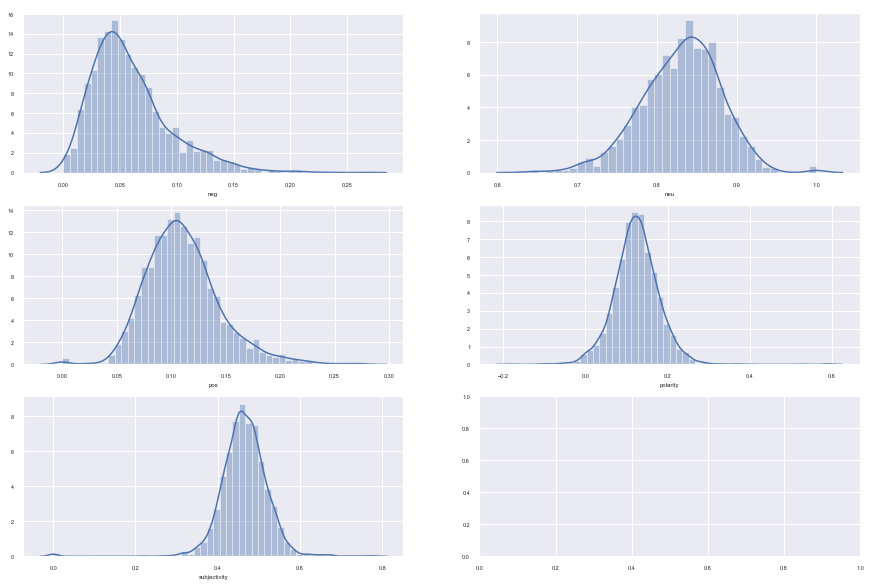

In [36]:
f, axes = plt.subplots(3,2,figsize=(15,10))
axes = axes.flatten()
for k,v in enumerate(sent.columns):
    sns.distplot(sent[v], kde=True,ax=axes[k])

In [37]:
comb = pd.concat([df,sent],axis=1)

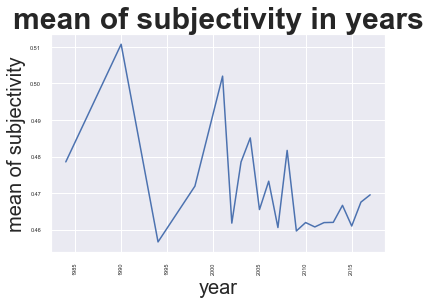

In [38]:
groupline(comb,'year','subjectivity')

In [39]:
col = [i for i in comb.columns if comb[i].dtype in ['int64', 'float64'] and 'id' not in i]

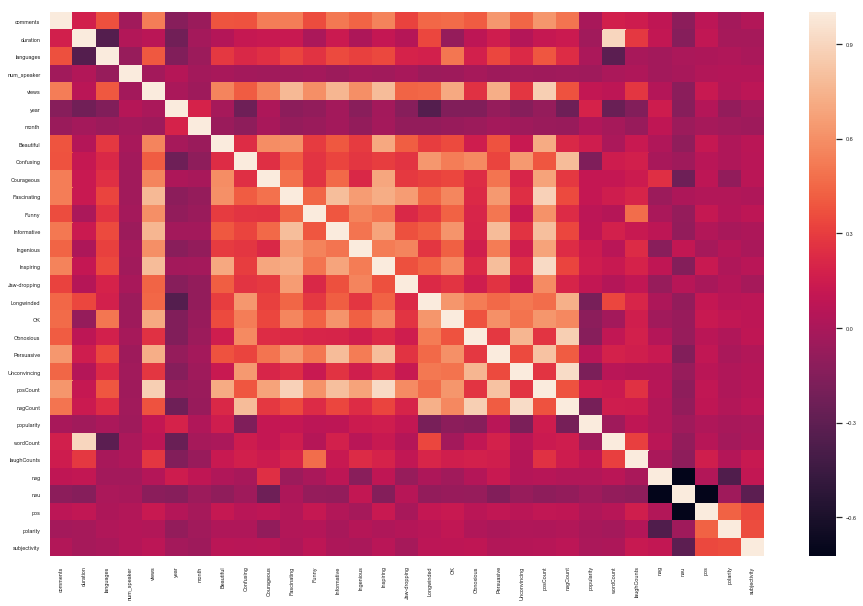

In [40]:
fig, ax = plt.subplots(figsize=(16,10))  
sns.heatmap(comb[col].corr(),xticklabels=True, yticklabels=True)

## Step 5 Topic Modeling

### Tf-idf

In [41]:
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True,min_df=0.05,max_df=0.3)
tfidf = vectorizer.fit_transform(df['transcript'])

In [42]:
sums = tfidf.sum(axis=0)
terms = vectorizer.get_feature_names()

In [43]:
lst=[]
for col,term in enumerate(terms):
    lst.append((term,sums[0,col]))
ranked = pd.DataFrame(lst,columns=['term','rank']).sort_values('rank',ascending=False)

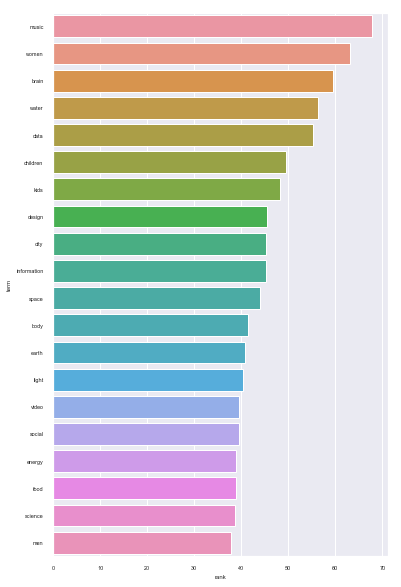

In [44]:
fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], ax=ax);

In [45]:
## Topic Model
n_topics = 9
lda = LDA(n_components=n_topics)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]

D:\JUPYTER\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


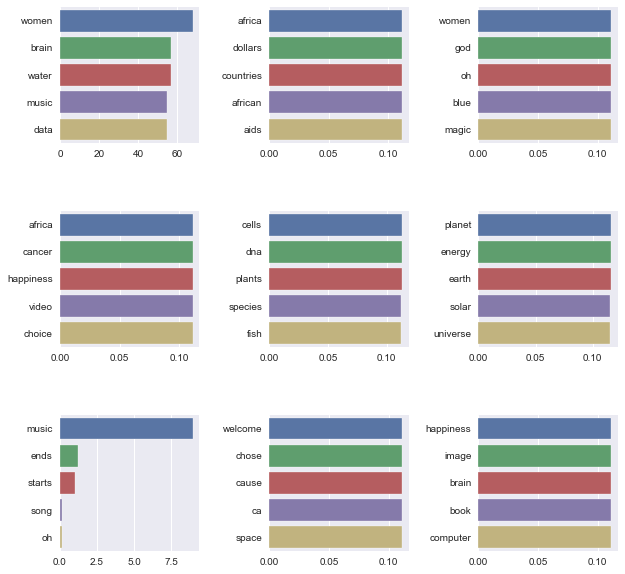

In [46]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,3):
    for col in range(0,3):
        sns.barplot(x=word_strengths[c], y=t_words[c], ax=ax[row][col])
        c+=1
plt.show()

In [47]:
n_topics = 9
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]

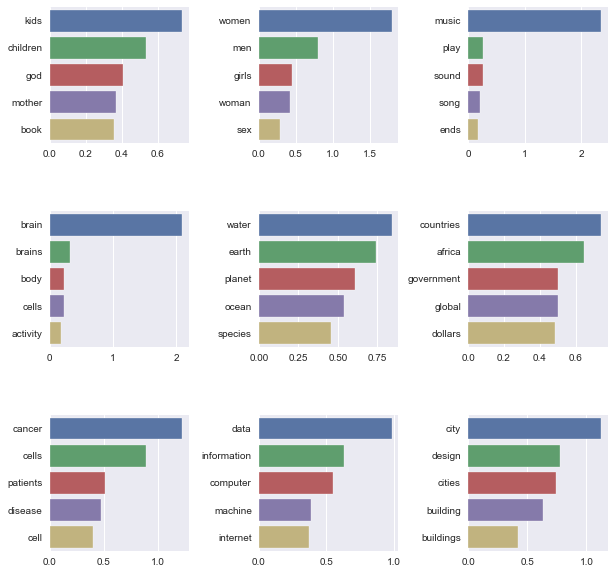

In [48]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,3):
    for col in range(0,3):
        sns.barplot(x=word_strengths[c], y=t_words[c], ax=ax[row][col])
        c+=1
plt.show()

In [49]:
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

In [50]:
t = pipe.transform(df['transcript']) 
t = pd.DataFrame(t, columns=[str(t_words[i]) for i in range(0,9)])
t.head()

,"['kids', 'children', 'god', 'mother', 'book']","['women', 'men', 'girls', 'woman', 'sex']","['music', 'play', 'sound', 'song', 'ends']","['brain', 'brains', 'body', 'cells', 'activity']","['water', 'earth', 'planet', 'ocean', 'species']","['countries', 'africa', 'government', 'global', 'dollars']","['cancer', 'cells', 'patients', 'disease', 'cell']","['data', 'information', 'computer', 'machine', 'internet']","['city', 'design', 'cities', 'building', 'buildings']"
0,0.109651,0.028074,0.029282,0.021516,0.016328,0.005965,0.000000,0.000000,0.000000
1,0.024296,0.000000,0.001639,0.000000,0.038113,0.071312,0.000000,0.010231,0.040137
2,0.054900,0.000000,0.040300,0.000000,0.000000,0.011019,0.000000,0.102050,0.010135
3,0.018195,0.011202,0.000000,0.000000,0.019212,0.068159,0.000742,0.000000,0.151502
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.137370,0.000000,0.064777,0.000000


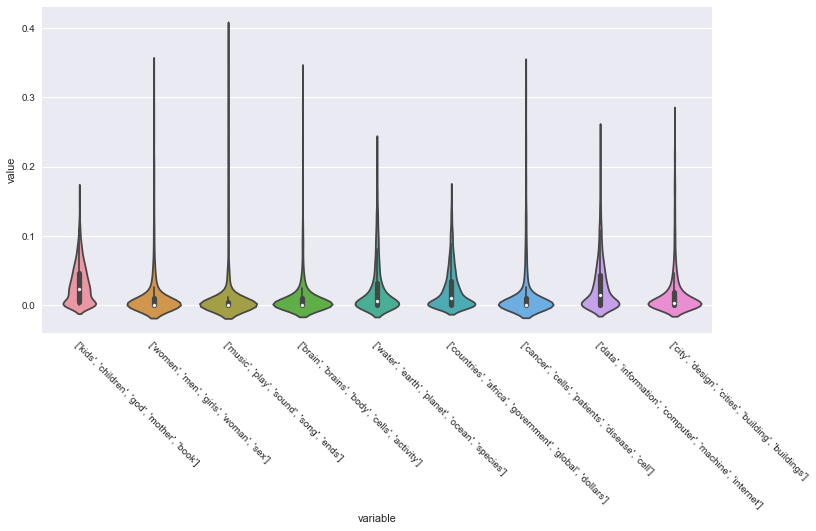

In [51]:
new_t = t.melt()

# fig = plt.figure(1,figsize=(12,6))
fig, ax = plt.subplots(figsize=(12,6), ncols=1, nrows=1)
sns.violinplot(x="variable", y="value", data=new_t, ax=ax)
# plt.xticks(rotation=75)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
plt.show()

In [52]:
### category topics
t.columns.values.tolist()

["['kids', 'children', 'god', 'mother', 'book']",
 "['women', 'men', 'girls', 'woman', 'sex']",
 "['music', 'play', 'sound', 'song', 'ends']",
 "['brain', 'brains', 'body', 'cells', 'activity']",
 "['water', 'earth', 'planet', 'ocean', 'species']",
 "['countries', 'africa', 'government', 'global', 'dollars']",
 "['cancer', 'cells', 'patients', 'disease', 'cell']",
 "['data', 'information', 'computer', 'machine', 'internet']",
 "['city', 'design', 'cities', 'building', 'buildings']"]

In [53]:
topicC = ['IT','Gender Topics','Music','Brains Researcg','Ecosystem','Politics and Economy','Disease','Education','City Design']
t.columns = topicC

In [54]:
final = pd.concat([comb, t],axis=1)
final['topicSum'] = final.loc[:,topicC].sum(axis=1)

In [55]:
final.to_csv('final.csv',index=False)

In [56]:
dic ={}
lst = topicC+['views','comments']
for i in lst:
    dic[i]=final.groupby('year')[i].mean()

In [57]:
df2 = pd.DataFrame(dic)
df2 = df2[df2.index>2001]
df2.reset_index(inplace=True)
df2['topicSum'] = df2.loc[:,topicC].sum(axis=1)
for i in topicC:
    df2[i]=df2[i]/df2['topicSum']

In [58]:
df2.to_csv('topic.csv',index=False)

#### visualization in Tableau

In [59]:
from PIL import Image

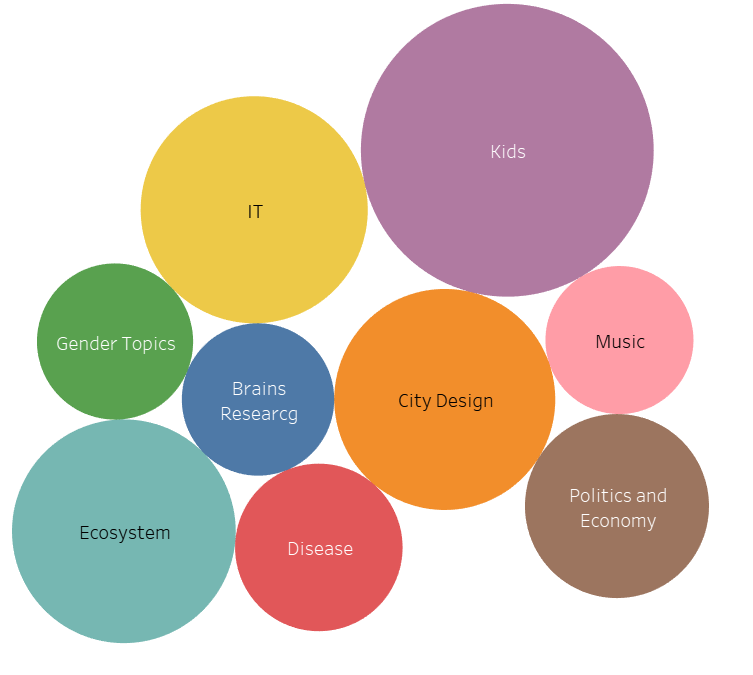

In [60]:
Image.open('2.png')

In [61]:
plt.style.use('ggplot')

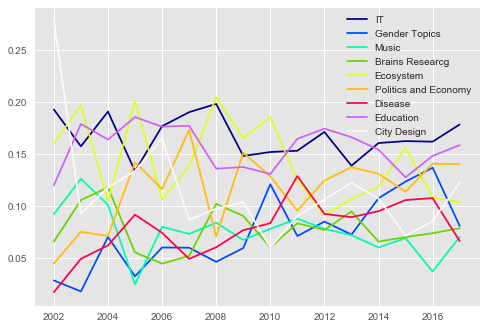

In [62]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in topicC:
    ax1.plot(df2['year'],df2[i],label=i)
    
colormap = plt.cm.gist_ncar  
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
ax1.legend(loc=1)